In [560]:
import pandas as pd
df = pd.read_csv('diabetes.csv')

In [561]:
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [562]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [563]:
print(df.shape)

(768, 9)


In [564]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


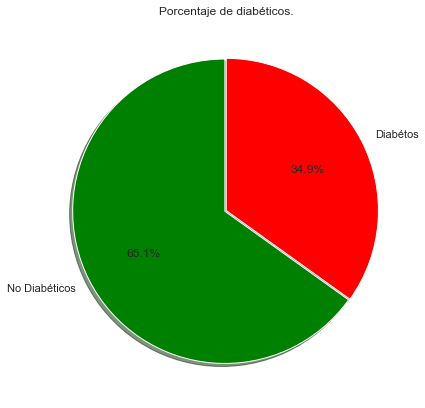

In [565]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [566]:
df_values = df.values
x = df_values[:,:-1]
y = df_values[:, -1].reshape(x.shape[0], 1)

In [567]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers

In [568]:
# Instantiate the model.
model = Sequential()
model.add(Dense(1,activation='sigmoid', input_shape=(x.shape[1],)))

# Printing the model summary.
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [569]:
# Mean, columnar axis.
x_mean = np.mean(x, axis=0, keepdims=True)

# Std. Deviation, columnar axis.
x_std = np.std(x, axis=0, keepdims=True)

# Normalizing.
x = (x - x_mean)/x_std

print(x[:5, :])

[[ 0.63994726  0.84832379  0.14964075  0.90726993 -0.69289057  0.20401277
   0.46849198  1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575  0.53090156 -0.69289057 -0.68442195
  -0.36506078 -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 -1.28821221 -0.69289057 -1.10325546
   0.60439732 -0.10558415]
 [-0.84488505 -0.99820778 -0.16054575  0.15453319  0.12330164 -0.49404308
  -0.92076261 -1.04154944]
 [-1.14185152  0.5040552  -1.50468724  0.90726993  0.76583594  1.4097456
   5.4849091  -0.0204964 ]]


In [570]:
from sklearn.model_selection import train_test_split

# Split the model into a 0.9-0.1 train-test split.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=5)

print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (691, 8)
Shape of y_train:  (691, 1)
Shape of x_test:  (77, 8)
Shape of y_test:  (77, 1)


In [571]:
import tensorflow as tf
from keras import backend as K

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [572]:
def plot_loss(model):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [573]:
from tensorflow.keras import optimizers
def get_loss_with_params(lr = 0.01, momentum=0.9):
    opt = optimizers.SGD(learning_rate=lr, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metrics.AUC(), specificity,sensitivity,
            negative_predictive_value, positive_predictive_value])
    # Fit the data to the model and get the per-batch metric history.
    history = model.fit(x_train, y_train, validation_split=0.2, 
                        batch_size=32, epochs=70, 
                    verbose=0)
    return history.history['val_loss'][-1], lr, momentum


In [574]:
import math
min_loss = math.inf
min_lr = math.inf
min_mom = math.inf
for learning_rate in range(1, 10):
    for momentum in range(1, 10):
        print('Learning Rate: ' + str(learning_rate/100))
        print('Momentum: ' + str(momentum/100))
        loss, lr, mom = get_loss_with_params(learning_rate/100, momentum/100)
        if (loss<min_loss):
            min_loss = loss
            min_lr = lr
            min_mom = mom
print('Val Loss: ' + str(min_loss) + '---- LR: ' + str(min_lr) + '---- Momentum: ' + str(min_mom))


Learning Rate: 0.01
Momentum: 0.01
Learning Rate: 0.01
Momentum: 0.02
Learning Rate: 0.01
Momentum: 0.03
Learning Rate: 0.01
Momentum: 0.04
Learning Rate: 0.01
Momentum: 0.05
Learning Rate: 0.01
Momentum: 0.06
Learning Rate: 0.01
Momentum: 0.07
Learning Rate: 0.01
Momentum: 0.08
Learning Rate: 0.01
Momentum: 0.09
Learning Rate: 0.02
Momentum: 0.01
Learning Rate: 0.02
Momentum: 0.02
Learning Rate: 0.02
Momentum: 0.03
Learning Rate: 0.02
Momentum: 0.04
Learning Rate: 0.02
Momentum: 0.05
Learning Rate: 0.02
Momentum: 0.06
Learning Rate: 0.02
Momentum: 0.07
Learning Rate: 0.02
Momentum: 0.08
Learning Rate: 0.02
Momentum: 0.09
Learning Rate: 0.03
Momentum: 0.01
Learning Rate: 0.03
Momentum: 0.02
Learning Rate: 0.03
Momentum: 0.03
Learning Rate: 0.03
Momentum: 0.04
Learning Rate: 0.03
Momentum: 0.05
Learning Rate: 0.03
Momentum: 0.06
Learning Rate: 0.03
Momentum: 0.07
Learning Rate: 0.03
Momentum: 0.08
Learning Rate: 0.03
Momentum: 0.09
Learning Rate: 0.04
Momentum: 0.01
Learning Rate: 0.04


In [580]:
opt = optimizers.SGD(learning_rate=min_lr, momentum=min_mom)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metrics.AUC(), specificity,sensitivity,
        negative_predictive_value, positive_predictive_value])
# Fit the data to the model and get the per-batch metric history.
history = model.fit(x_train, y_train, validation_split=0.2, 
                    batch_size=32, epochs=70, 
                verbose=1)

sitivity: 0.5383 - negative_predictive_value: 0.7973 - positive_predictive_value: 0.6752 - val_loss: 0.4659 - val_auc_141: 0.8389 - val_specificity: 0.8842 - val_sensitivity: 0.5610 - val_negative_predictive_value: 0.7504 - val_positive_predictive_value: 0.7568
Epoch 20/70
18/18 [==============================] - 0s 2ms/step - loss: 0.4763 - auc_141: 0.8389 - specificity: 0.8853 - sensitivity: 0.5453 - negative_predictive_value: 0.7942 - positive_predictive_value: 0.7066 - val_loss: 0.4676 - val_auc_141: 0.8389 - val_specificity: 0.8842 - val_sensitivity: 0.5610 - val_negative_predictive_value: 0.7504 - val_positive_predictive_value: 0.7568
Epoch 21/70
18/18 [==============================] - 0s 2ms/step - loss: 0.4760 - auc_141: 0.8390 - specificity: 0.8888 - sensitivity: 0.5662 - negative_predictive_value: 0.7858 - positive_predictive_value: 0.7412 - val_loss: 0.4678 - val_auc_141: 0.8389 - val_specificity: 0.8842 - val_sensitivity: 0.5610 - val_negative_predictive_value: 0.7504 - va

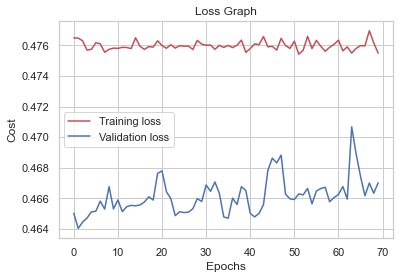

In [581]:
plot_loss(history)

In [582]:
predictions = model.predict(x_test)

In [583]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

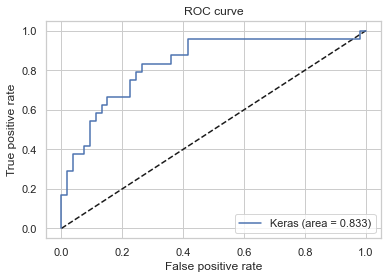

In [584]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [585]:
from sklearn.metrics import confusion_matrix
rounded_preds = np.rint(predictions)
confusion_matrix(y_test, rounded_preds)

array([[45,  8],
       [ 8, 16]], dtype=int64)

In [586]:
from sklearn.metrics import precision_score
rounded_preds = np.rint(predictions)

print('Specificity: ' + str(specificity(y_test.astype(float), rounded_preds.astype(float))))
print('Sensitivity: ' + str(sensitivity(y_test.astype(float), rounded_preds.astype(float))))
print('Positive Predictive Value: ' + str(positive_predictive_value(y_test.astype(float), rounded_preds.astype(float))))
print('Negative Predictive Value: ' + str(negative_predictive_value(y_test.astype(float), rounded_preds.astype(float))))

Specificity: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
